In [2]:
import os
import socket
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
country_code = "US"
print('Country:', country_code)

min_date = '1/1/2012'
print('Min date:', min_date)

Country: US
Min date: 1/1/2012


In [4]:
# Local
print('Hostname:', socket.gethostname())
if  'samuel' in socket.gethostname().lower():
    path_to_data='../../data'
# Cluster
else:
    path_to_data='/scratch/spf248/twitter/data'
    
path_to_predictions=os.path.join(path_to_data,'mentions')
path_to_keywords=os.path.join(path_to_data,'keywords','labor')
path_to_official_data=os.path.join(path_to_data,'official')
print(path_to_predictions)
print(path_to_official_data)

Hostname: Samuels-MBP.home
../../data/mentions
../../data/official


# Twitter Labor Market Indicators

In [5]:
wordlists=pd.DataFrame()
for file in glob(os.path.join(path_to_keywords,country_code,country_code+'*')):
    targets=pd.read_csv(file,squeeze=True,header=None).sort_values().reset_index(drop=True).rename('target').to_frame()
    targets['wordlist']=re.findall('-([a-z]+).',file)[0]
    wordlists=pd.concat([wordlists,targets.reset_index()])
wordlists=wordlists.sort_values(by=['wordlist','index']).set_index(['wordlist','index'])['target']

In [6]:
wordlists

wordlist    index
hire        0                  Finally found a job today
            1            Finally started a new job today
            2           Finally started my new job today
            3                    I found a new job today
            4                      I got a new job today
                                    ...                 
unemployed  11                I'm tired of being jobless
            12             I'm tired of being unemployed
            13                   I'm trying to get a job
            14       Waiting + my unemployment insurance
            15        waiting + my unemployment benefits
Name: target, Length: 140, dtype: object

In [7]:
print('Import Mentions Counts')
start = timer()
predictions=pq.ParquetDataset(glob(os.path.join(path_to_predictions,country_code,'*.parquet'))).read().to_pandas()
print('# obs:', predictions.shape[0])
print("Done in", round(timer()-start), "sec")

Import Mentions Counts
# obs: 5225084
Done in 21 sec


In [8]:
print('Rename')
start = timer()
predictions.year=predictions.year.astype(int)
predictions.month=predictions.month.astype(int)
predictions.rename(
columns=lambda x:'n_'+re.findall('([a-z]+)-(\d+)',x)[0][0]+'_'+\
wordlists.loc[re.findall('([a-z]+)-(\d+)',x)[0][0]][int(re.findall('([a-z]+)-(\d+)',x)[0][1])] if '-' in x else x,inplace=True)
predictions = predictions.loc[:,~predictions.columns.duplicated()].copy()
print("Done in", round(timer()-start), "sec")

Rename
Done in 49 sec


In [9]:
predictions.filter(regex='n_').sum().sort_values(ascending=False).head(30)

n_users                                 143114753
n_offer                                    352305
n_offer_#hiring                            131227
n_offer_We're hiring                        80490
n_search                                    62583
n_offer_Job opportunity                     62264
n_search_I need a job                       55943
n_offer_Apply here                          47282
n_offer_we are hiring                       46327
n_offer_Send your resume                     8393
n_loss                                       5801
n_hire                                       5072
n_unemployed                                 4360
n_unemployed_I wish I had a job              2595
n_hire_I just got hired                      1846
n_search_Anyone hiring?                      1711
n_search_I'm looking for a job               1508
n_loss_I just got fired                      1325
n_loss_Just lost my job                      1237
n_hire_Started my new job today              1075


In [10]:
predictions.head()

,year,month,user_location,n_search_I am looking for job offers,n_hire_Started my new position today,n_search_I have been applying for jobs,n_hire_I got a new job today,n_hire_I just found new job,n_offer_Send your resume,n_search_I am available for any job opportunity,...,n_loss_I've been fired,n_loss_I have just been fired,n_hire_Starting my new position tomorrow,n_loss_Lost my job today,n_loss_I just got the sack,n_search_I'm applying + indeed.com,n_unemployed_I have had no luck finding a job,n_hire_I have finally started my new job,n_offer_Apply here,n_search
0,2009,10,"Redding, CA",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2009,4,nashville,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2009,8,"Pennsylvania, USA",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2010,11,Pittsburgh,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,1,"Boulder, CO",0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# Twitter Account Locations Geocoded

In [11]:
locations=pd.read_pickle(os.path.join(path_to_data,'locations','profiles','account-locations.pkl'))
locations=locations[locations.country_short==country_code].drop(['n_users','latitude','longitude','country_long','country_short'],1).reset_index(drop=True)

In [12]:
locations.head()

,user_location,locality_long,locality_short,administrative_area_level_1_long,administrative_area_level_1_short,administrative_area_level_2_long,administrative_area_level_2_short
0,New York,New York,New York,New York,NY,NaN,NaN
1,Los Angeles,Los Angeles,Los Angeles,California,CA,Los Angeles County,Los Angeles County
2,"Los Angeles, CA",Los Angeles,Los Angeles,California,CA,Los Angeles County,Los Angeles County
3,Chicago,Chicago,Chicago,Illinois,IL,Cook County,Cook County
4,"New York, NY",New York,New York,New York,NY,NaN,NaN


# Aggregate labor market statistics

In [13]:
aggregates=pd.read_csv(os.path.join(path_to_official_data,'aggregates','monthly.csv'))
aggregates=aggregates[['date',country_code]].copy()
aggregates['year']=aggregates['date'].map(lambda x:pd.to_datetime(x).year)
aggregates['month']=aggregates['date'].map(lambda x:pd.to_datetime(x).month)
aggregates.rename(columns={country_code:'unemployment_rate'},inplace=True)
aggregates.drop('date',1,inplace=True)
aggregates['unemployment_rate']/=100

In [14]:
aggregates.head()

,unemployment_rate,year,month
0,0.106,2010,1
1,0.104,2010,2
2,0.102,2010,3
3,0.095,2010,4
4,0.093,2010,5


In [15]:
print('Merge and Aggregate')
start = timer()
df=pd.merge(predictions,locations[['user_location']]).drop('user_location',1)
df=df.groupby(['year','month'],as_index=False).sum()
df=pd.merge(aggregates,df)
df['date']=df[['year','month']].apply(lambda x:'-'.join([str(y) for y in x]),1)
df=pd.concat([
df.filter(regex='n_').drop('n_users',1).divide(
df.n_users,axis=0).rename(columns=lambda x:x.replace('n_','pct_')),
df.drop(df.drop('n_users',1).filter(regex='n_').columns,1).drop(['year','month'],1)],1)
df['datetime']=pd.to_datetime(df.date)
print("Done in", round(timer()-start), "sec")

Merge and Aggregate
Done in 21 sec


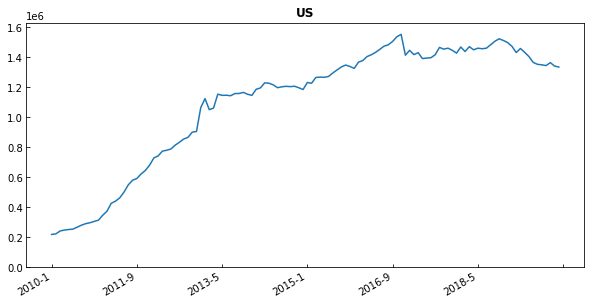

In [16]:
fig,ax=plt.subplots(figsize=(10,5))
df.plot(ax=ax,y='n_users',x='date',style='-',markersize=2,legend=False)
ax.set_xlabel('')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
ax.set_title(country_code,fontweight='bold')
ax.locator_params(axis='both',nbins=10)
ax.set_ylim([0,df.n_users.max()*1.05])
fig.autofmt_xdate()

In [17]:
label = df.corr()['unemployment_rate'].dropna().sort_values(ascending=False).index[1]
df.corr()['unemployment_rate'].dropna().sort_values(ascending=False).head(20)

unemployment_rate                         1.000000
pct_search                                0.879517
pct_unemployed                            0.868183
pct_search_I need a job                   0.860517
pct_unemployed_I wish I had a job         0.824117
pct_search_I'm looking for a job          0.789843
pct_search_Anyone hiring?                 0.750919
pct_search_I can't find a job             0.709710
pct_search_I am looking for a job         0.668115
pct_unemployed_I am unemployed            0.663674
pct_hire_Starting my new job tomorrow     0.662274
pct_search_I'm looking for a new job      0.645925
pct_offer_Send your resume                0.608104
pct_search_I'm trying to get a job        0.583431
pct_unemployed_I'm trying to get a job    0.583431
pct_hire                                  0.472986
pct_unemployed_I am jobless               0.470843
pct_search_I wish I could find a job      0.416650
pct_loss_Lost my job today                0.407823
pct_loss                       

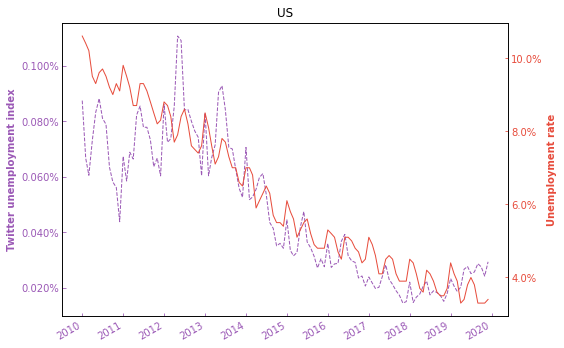

In [110]:
fig,ax1=plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
colors = ["#9b59b6", "#95a5a6", "#3498db", "#2ecc71", "#e74c3c", "#34495e"]
ax1.plot(df['datetime'],df[label],linewidth=1,color=colors[0],linestyle='dashed',label='Unemployment rate')
ax2.plot(df['datetime'],df['unemployment_rate'],linewidth=1,color=colors[4])
ax1.tick_params(which='both',direction='in',pad=3,colors=colors[0])
ax2.tick_params(which='both',direction='in',pad=3,colors=colors[4])
ax1.locator_params(axis='y',nbins=8)
ax2.locator_params(axis='y',nbins=8)
ax1.set_xlabel('')
ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()])
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()])
ax1.set_ylabel('Twitter unemployment index',fontweight='bold',color=colors[0])
ax2.set_ylabel('Unemployment rate',fontweight='bold',color=colors[4])
ax1.set_title(country_code)
fig.autofmt_xdate()
plt.savefig(os.path.join(path_to_data,'../fig/','aggregates',country_code+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')

# Subnational estimates

In [461]:
admin = pd.read_csv(os.path.join(path_to_official_data,'admin',country_code+'.csv'))
# admin.rename(columns={'unemployed':'unemployment_rate','employed':'employment_rate'},inplace=True)
# admin.drop(['quarter'],1,inplace=True)
# admin = admin[admin['urban_or_rural']=='Urban'].drop('urban_or_rural',1).reset_index(drop=True)
# admin['unemployment_rate']/=100
# admin['employment_rate']/=100

In [387]:
code2name = pd.read_csv(os.path.join(path_to_official_data,'admin',country_code+'-admin1.csv'),header=None,names=['administrative_area_level_1','administrative_area_level_1_long'])
code2name = code2name.applymap(eval)
name2code=code2name.set_index('administrative_area_level_1_long')['administrative_area_level_1'].to_dict()

In [450]:
df = pd.merge(locations,predictions).drop('user_location',1)
df = df.loc[:,~df.columns.duplicated()].copy()
df['administrative_area_level_1'] = df['administrative_area_level_1_long'].apply(lambda x:float(name2code.get(x,np.nan)))
df = df.groupby(['year','month','administrative_area_level_1'],as_index=False).sum()
df['date'] = df[['year','month']].apply(lambda x:'-'.join([str(y) for y in x]),1)
df = pd.concat([df.filter(regex='n_').drop('n_users',1).divide(
df.n_users,axis=0).rename(columns=lambda x:x.replace('n_','pct_')),
df.drop(df.drop('n_users',1).filter(regex='n_').columns,1).drop(['year','month'],1)],1)

# df = pd.merge(admin,df,on=['year','month','administrative_area_level_1'])

In [455]:
admin.shape

(3485, 5)

In [456]:
df.shape

(4622, 372)

In [460]:
admin.head()

,year,month,administrative_area_level_1,unemployment_rate,employment_rate
0,2012,1,1,0.032509,0.513872
1,2012,1,1,0.036685,0.501146
2,2012,1,2,0.033583,0.502131
3,2012,1,2,0.000000,1.000000
4,2012,1,3,0.039378,0.578652


# Subnational estimates

In [90]:
admin = pd.read_csv(os.path.join(path_to_official_data,'admin',country_code+'.csv'),index_col=0)
admin = admin.groupby(['year','month','administrative_area_level_1_short'],as_index=False).mean()
admin['unemployment_rate']/=100

/Users/samuelfraiberger/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [91]:
print('Merge and aggregate')
start = timer()
df = pd.merge(locations,predictions).drop('user_location',1)
df = df.groupby(['year','month','administrative_area_level_1_short'],as_index=False).sum()
df = pd.merge(admin,df,on=['year','month','administrative_area_level_1_short'])
df['date'] = df[['year','month']].apply(lambda x:'-'.join([str(y) for y in x]),1)
df = pd.concat([df.filter(regex='n_').drop('n_users',1).divide(
df.n_users,axis=0).rename(columns=lambda x:x.replace('n_','pct_')),
df.drop(df.drop('n_users',1).filter(regex='n_').columns,1).drop(['year','month'],1)],1)
df['datetime'] = pd.to_datetime(df['date'])
top_admins=df.groupby('administrative_area_level_1_short').n_users.sum().sort_values(ascending=False).head(5).index
print("Done in", round(timer()-start), "sec")

Merge and aggregate
Done in 35 sec


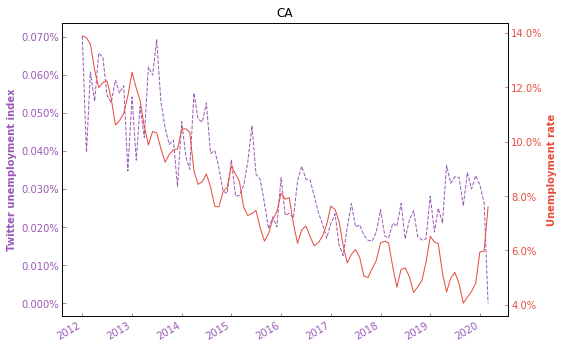

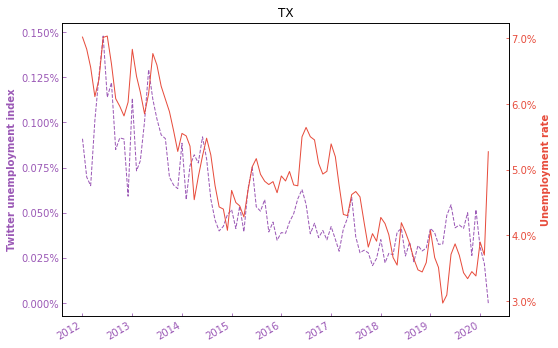

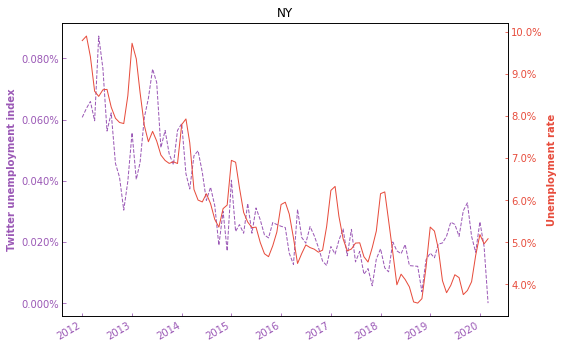

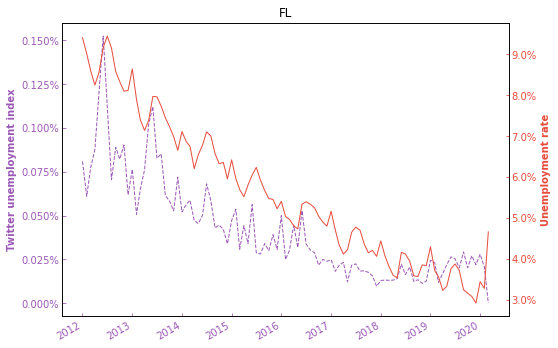

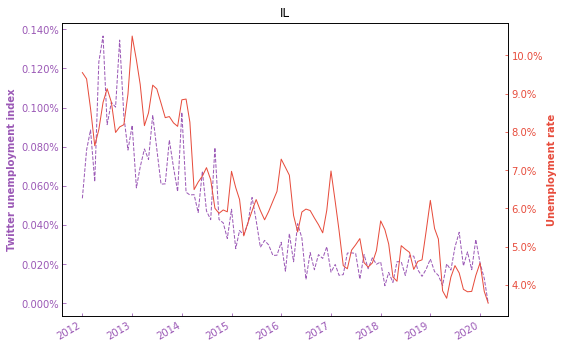

In [105]:
for admin in top_admins:
    fig,ax1=plt.subplots(figsize=(8,6))
    ax2 = ax1.twinx()
    colors = ["#9b59b6", "#95a5a6", "#3498db", "#2ecc71", "#e74c3c", "#34495e"]
    ax1.plot(df[(df['administrative_area_level_1_short']==admin)&(df['datetime']>=pd.to_datetime(min_date))]['datetime'],
             df[(df['administrative_area_level_1_short']==admin)&(df['datetime']>=pd.to_datetime(min_date))][label],
             linewidth=1,
             color=colors[0],
             linestyle='dashed',
             label='Unemployment rate')
    ax2.plot(df[(df['administrative_area_level_1_short']==admin)&(df['datetime']>=pd.to_datetime(min_date))]['datetime'],
             df[(df['administrative_area_level_1_short']==admin)&(df['datetime']>=pd.to_datetime(min_date))]['unemployment_rate'],
             linewidth=1,
             color=colors[4])
    ax1.tick_params(which='both',direction='in',pad=3,colors=colors[0])
    ax2.tick_params(which='both',direction='in',pad=3,colors=colors[4])
    ax1.locator_params(axis='y',nbins=8)
    ax2.locator_params(axis='y',nbins=8)
    ax1.set_xlabel('')
    ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()])
    ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()])
    ax1.set_ylabel('Twitter unemployment index',fontweight='bold',color=colors[0])
    ax2.set_ylabel('Unemployment rate',fontweight='bold',color=colors[4])
    ax1.set_title(admin)
    fig.autofmt_xdate()
    plt.savefig(os.path.join(path_to_data,'../fig/',country_code,admin+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')